In [1]:
from utils.data_set import get_data_json, extract_data_set_info
from utils.matrix import fix_diagonal_weight
from itertools import product
from model.model import BSS
from typing import Set, List, Tuple
import networkx as nx
import mip
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
try:
    data_set = get_data_json("../../data/ReggioEmilia/4ReggioEmilia30.json")

    (num_vertices, demands, vehicle_capacity, distance_matrix) = extract_data_set_info(
        data_set
    )

    fix_diagonal_weight(distance_matrix)

    V = set(range(num_vertices))
    A = {(i, j): distance_matrix[i, j] for i in V for j in V}
    m = 1
    Q = vehicle_capacity
    q = demands
    c = distance_matrix

    problem = BSS(V, A, m, Q, q, c)
except Exception as e:
    raise e

2024-08-29 17:30:05.485 | SUCCESS  | utils.data_set:get_data_json:23 - JSON file loaded correctly


In [3]:
class SubTourElimination(mip.ConstrsGenerator):
    def __init__(
        self,
        forced_arcs: List[Tuple[int, int]],
        vertices: Set[int],
        decision_vars: List[List[mip.Var]],
    ):
        self.forced_arcs = forced_arcs
        self.vertices = vertices
        self.decision_vars = decision_vars

    def generate_constrs(self, model: mip.Model, depth: int = 0, npass: int = 0):
        translated_vars, vertices, cut_pool, graph = (
            model.translate(self.decision_vars),
            self.vertices,
            mip.CutPool(),
            nx.DiGraph(),
        )

        for source, target in [
            (i, j)
            for i, j in product(vertices, vertices)
            if i != j and translated_vars[i][j]
        ]:
            graph.add_edge(source, target, capacity=translated_vars[source][target].x)

        for source, target in self.forced_arcs:
            cut_value, (subset, _) = nx.minimum_cut(graph, source, target)
            if cut_value <= 0.99:
                active_arcs = [
                    (translated_vars[i][j], translated_vars[i][j].x)
                    for (i, j) in product(vertices, vertices)
                    if i != j and translated_vars[i][j] and i in subset and j in subset
                ]

                if sum(flow for _, flow in active_arcs) >= len(subset) - 1:
                    subtour_elimination_cut = (
                        mip.xsum(1.0 * var for var, _ in active_arcs) <= len(subset) - 1
                    )
                    cut_pool.add(subtour_elimination_cut)
        for cut in cut_pool.cuts:
            model += cut

In [4]:
problem.V, len(problem.A)

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}, 196)

In [5]:
problem.Q, problem.q

(30, [0, -3, 1, 2, -5, 2, -10, -2, -2, 3, -1, -6, -9, 2])

In [6]:
df = pd.DataFrame(problem.c)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,3700,4000,3900,4900,3900,4800,3800,4000,2600,4600,3800,3000,3500
1,4300,0,1300,300,2400,1200,1300,2600,1600,1200,1000,600,1400,800
2,4500,900,0,900,2100,900,1000,1900,1300,2100,700,1400,2200,500
3,4500,300,1300,0,2200,1200,1000,2500,1600,1500,700,800,1600,800
4,5500,2200,2600,2000,0,3100,1200,3600,3200,2500,1800,2000,2600,2700
5,3700,800,900,1100,2900,0,1800,1500,500,2000,1500,1300,1700,400
6,5300,1400,1800,1100,2000,2300,0,2700,2300,2200,900,1800,2400,1900
7,3500,2200,1700,2400,3600,1500,2400,0,1400,3000,2400,2600,2700,1800
8,4300,800,1100,1000,3100,1000,2000,1500,0,1600,1700,1200,1300,600
9,3300,1600,2600,1800,2300,2500,2200,3000,2700,0,2100,1200,800,2100


In [7]:
problem.f = {
    (i, j): problem.model.add_var(name=f"f_{i}_{j}", var_type=mip.INTEGER)
    for i in V
    for j in V
}

In [8]:
problem.model += mip.xsum(problem.f[i, i] for i in V) == 0

for j in V - {0}:
    problem.model += (
        mip.xsum(problem.f[j, i] for i in V if i != j)
        - mip.xsum(problem.f[i, j] for i in V if i != j)
        == q[j]
    )

for i in V:
    for j in V:
        if i != j:
            flow_lower_bound = max(0, q[i], -q[j]) * problem.x[i][j]
            flow_upper_bound = min(Q, Q + q[i], Q - q[j]) * problem.x[i][j]

            problem.model += problem.f[i, j] >= flow_lower_bound
            problem.model += problem.f[i, j] <= flow_upper_bound

In [9]:
farthest_pairs = []
graph = nx.DiGraph()

for start, end in problem.A:
    graph.add_edge(start, end, weight=int(problem.c[start, end]))

for vertex in problem.V:
    _, distances = nx.dijkstra_predecessor_and_distance(graph, source=vertex)
    sorted_distances = sorted(distances.items(), key=lambda x: x[1], reverse=True)
    farthest_vertex = sorted_distances[0][0]
    farthest_pairs.append((vertex, farthest_vertex))

In [10]:
problem.model.cuts_generator = SubTourElimination(farthest_pairs, V, problem.x)
problem.model.optimize()

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Clp0024I Matrix will be packed to eliminate 53 small elements
Coin0506I Presolve 352 (-57) rows, 364 (-28) columns and 1298 (-147) elements
Clp1000I sum of infeasibilities 0.323258 - average 0.000918347, 103 fixed columns
Coin0506I Presolve 238 (-114) rows, 235 (-129) columns and 923 (-375) elements
Clp0029I End of values pass after 235 iterations
Clp0014I Perturbing problem by 0.001% of 4.8101535 - largest nonzero change 5.5708976e-05 ( 0.00096646154%) - largest zero change 2.982246e-05
Clp0000I Optimal - objective value 18187.381
Clp0000I Optimal - objective value 18187.381
Coin0511I After Postsolve, objective 18187.381, infeasibilities - dual 0 (0), primal 0 (0)
Clp0014I Perturbing problem by 0.001% of 5.1837674 - largest nonzero change 5.3569463e-05 ( 0.00082704334%) - largest zero change 2.982246e-05
Clp0000I Optimal - object

<OptimizationStatus.OPTIMAL: 0>

In [11]:
if problem.model.num_solutions:
    optimal_route = [
        (origin, destination)
        for origin in V
        for destination in V
        if problem.x[origin][destination].x >= 0.5
    ]
    optimal_flow = [
        (origin, destination)
        for origin in V
        for destination in V
        if problem.f[origin, destination].x and problem.x[origin][destination].x >= 0.5
    ]

    for origin, destination in optimal_route:
        variable_name = f"x_{origin}_{destination}"
        variable_value = problem.x[origin][destination].x
        print(f"{problem.model.var_by_name(variable_name)} = {variable_value}")

x_0_7 = 1.0
x_1_13 = 1.0
x_2_10 = 1.0
x_3_1 = 1.0
x_4_6 = 1.0
x_5_8 = 1.0
x_6_3 = 1.0
x_7_2 = 1.0
x_8_7 = 1.0
x_9_4 = 1.0
x_10_11 = 1.0
x_11_12 = 1.0
x_12_0 = 1.0
x_12_9 = 1.0
x_13_5 = 1.0


In [12]:
print("Initial demand at each station:")
for station, demand in enumerate(q):
    print(f"Station {station}: {demand}")

print("\nOptimal flow between stations:")
for origin, destination in optimal_flow:
    flow_var_name = f"f_{origin}_{destination}"
    flow_value = problem.f[origin, destination].x
    print(f"Flow from Station {origin} to Station {destination}: {flow_value}")

Initial demand at each station:
Station 0: 0
Station 1: -3
Station 2: 1
Station 3: 2
Station 4: -5
Station 5: 2
Station 6: -10
Station 7: -2
Station 8: -2
Station 9: 3
Station 10: -1
Station 11: -6
Station 12: -9
Station 13: 2

Optimal flow between stations:
Flow from Station 0 to Station 7: 28.0
Flow from Station 2 to Station 10: 29.0
Flow from Station 3 to Station 1: 3.0
Flow from Station 4 to Station 6: 11.0
Flow from Station 5 to Station 8: 4.0
Flow from Station 6 to Station 3: 1.0
Flow from Station 7 to Station 2: 28.0
Flow from Station 8 to Station 7: 2.0
Flow from Station 9 to Station 4: 16.0
Flow from Station 10 to Station 11: 28.0
Flow from Station 11 to Station 12: 22.0
Flow from Station 12 to Station 9: 13.0
Flow from Station 13 to Station 5: 2.0


In [13]:
def plot_route(V, route, pos=None):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(route)

    if pos is None:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw all nodes except 0 in light blue
    nx.draw_networkx_nodes(
        G, pos, nodelist=set(V) - {0}, node_color="lightblue", node_size=500
    )

    # Draw node 0 in red
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red", node_size=500)

    nx.draw_networkx_labels(G, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=route, edge_color="grey", arrows=True)

    # Add edge labels (distances)
    edge_labels = {(i, j): f"{problem.c[i,j]}" for i, j in route}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Bike-sharing System Route")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

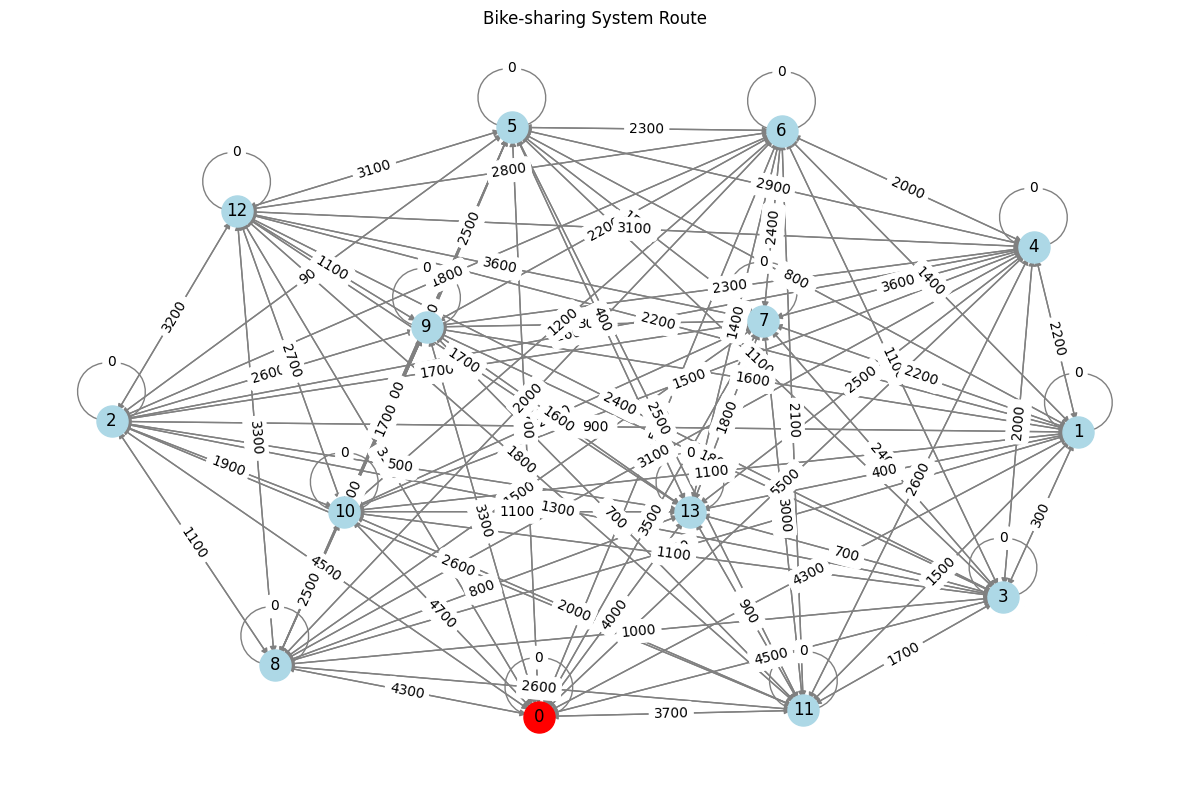

In [14]:
plot_route(V, A)

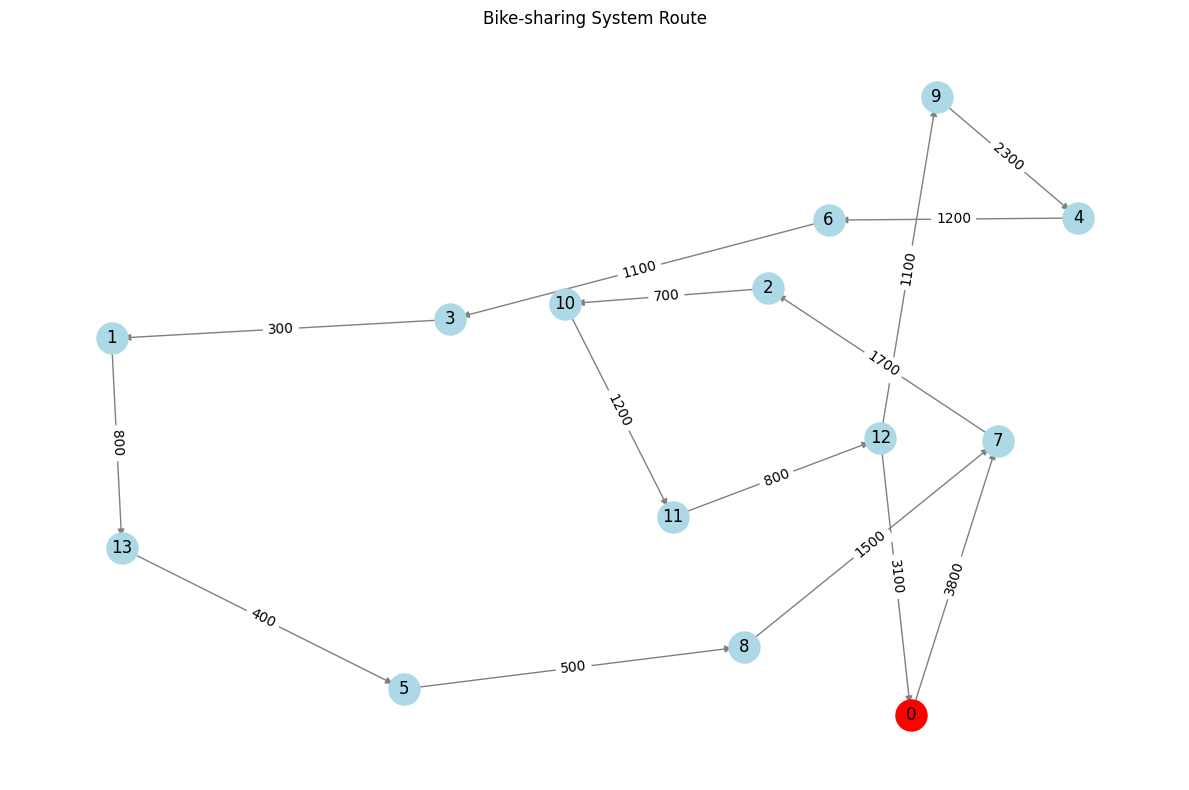

In [18]:
plot_route(V, optimal_route)